Instantiate a series of envs, divide that into train_envs and test_envs
   - When each env is instantiate:
     - trade(): ratio = S1/S2 -> returns1 = S1/S1.shift; returns2 = S2/S2.shift -> 
     - ma1 = ratio fast mov avg; ma2 = ratio slow moving avg
     - zscore = (ma1 - ma2)/std
     - -> self.df updated with zscore

Initialize policy_net, target_net (by load_state_dict from policy_net), optimizer, memory

Train policy network. For each episode:
- reset(): done, current_tick, position, positionhistory, total_reward, total_return, history -> get_observation() -> obs (zscore, [self._position.value, self.pvalue]) -> state
- select_action based on state, using epsilon-greedy algo: if random > eps threshold, then generate action from policy network; otherwise, random action
- env.step() based on chosen action -> obs, reward, done, info -> next_state = obs
- pushed to memory: memory.push(state, action, next_state, reward)
- state = next_state
- optimize_model(): 
   - transitions = sample a batch size from memory: memory.sample(BATCH_SIZE)
   - memory -> state_batch, action_batch, reward_batch
   - compute Q(s_t, a) (what the policy_net says based on state_batch): *state_action_values* = policy_net(state_batch)
   - Compute the expected Q values: non_final_mask and non_final_next_state -> next_state_values[non_final_mask] = target_net(non_final_next_states) ->  *expected_state_action_values* = (next_state_values * GAMMA) + reward_batch (from Bellman)
   - compute loss: criterion(state_action_values, expected_state_action_values) -> backprop
   - train_returns from "info"; stored as "total_returns" from df
   - update target network every 5 episodes with policy network parameters: target_net.load_state_dict(policy_net.state_dict())

Validate policy network:
- Instead of using select_action() (epsilon-greedy), use policy_net to generate action directly
- action -> env.step() based on policy_net's action -> obs, _reward, done, info -> state = obs
- test_returns from "info"; stored as "total returns" from df
- avg_rewards = np.mean(test_rewards) -> if avg_rewards > best_rewards -> best_rewards = avg_rewards -> torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

After training, policy_net can be recalled: 
- policy_net.load_state_dict(torch.load('./models/model (6).pth'))
- target_net.load_state_dict(policy_net.state_dict())
- set both nn to eval mode
- for each pair:
   - run it on test_env: loaded policy_net generates action -> obs, reward, done, info -> state = obs
   - render() to render charts
   - returns based on info['total return']



   


_init_ -> trade() -> self.df updated with zscore; self.returns is not invoked elsewhere

reset() invoked in main -> (zscore, [self._position.value, self.pvalue])

step() invoked in main -> take a step based on action returned by nn -> return observation, step_reward, self._done, info

get_observation() -> invoked in reset() -> return np.append(zscore, [self._position.value, self.pvalue])

render() invoked in main -> self.plot_returns_delta(mask), self.plot_prices(mask)

mask is copied from self._positionhistory, which is a list of self._position, which is action returned by nn (as an arg in step()). So, mask has values 0,1,2

plot_returns() -> not used

plot_returns_delta() -> returns1/returns 2 difference, buy/sell signals on top

plot_zscore() -> not used

plot_ratios() -> not used

plot_prices() -> 

Positions: Short(0) Flat(1) Long(2)

based on action, step(action) -> return new obs, _reward, done, info

In [1]:
import os
import gym
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from statsmodels.tsa.stattools import coint, adfuller

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

#from stock_trading_environment import StockTradingEnvironment, Positions

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
envs[0].df['600199.SH']

Date
2016-06-06     9.89
2016-06-07     9.98
2016-06-08     9.79
2016-06-13     9.40
2016-06-14    10.34
              ...  
2021-07-14    15.80
2021-07-15    16.58
2021-07-16    16.31
2021-07-19    16.39
2021-07-20    16.39
Name: 600199.SH, Length: 1247, dtype: float64

In [30]:
envs[0].df['600199.SH'].shift(1)

Date
2016-06-06      NaN
2016-06-07     9.89
2016-06-08     9.98
2016-06-13     9.79
2016-06-14     9.40
              ...  
2021-07-14    15.65
2021-07-15    15.80
2021-07-16    16.58
2021-07-19    16.31
2021-07-20    16.39
Name: 600199.SH, Length: 1247, dtype: float64

In [26]:
envs[0].df['600199.SH']

,603919.SH,600199.SH,ratios,zscore,position1,position2,returns1,returns2,strategy
Date,,,,,,,,,
2016-06-06,30.90,9.89,3.124368,0.272100,0.0,-0.0,0.000000,0.005068,0.0
2016-06-07,30.90,9.98,3.096192,0.296890,0.0,-0.0,0.000000,0.009059,0.0
2016-06-08,30.90,9.79,3.156282,0.314807,0.0,-0.0,0.000000,-0.019222,0.0
2016-06-13,30.90,9.40,3.287234,0.328019,0.0,-0.0,0.000000,-0.040652,0.0
2016-06-14,30.90,10.34,2.988395,0.180615,0.0,-0.0,0.000000,0.095310,0.0
...,...,...,...,...,...,...,...,...,...
2021-07-14,42.31,15.80,2.677848,-0.725918,0.0,-0.0,0.020536,0.009539,0.0
2021-07-15,43.94,16.58,2.650181,-0.662813,0.0,-0.0,0.037802,0.048187,0.0
2021-07-16,42.77,16.31,2.622318,-0.606918,0.0,-0.0,-0.026988,-0.016419,0.0


In [2]:
#copying stock_trading_environment code here for easier editing
#remember to copy back this to the stock_trading environment.py
from gym import spaces
from enum import Enum

class Positions(Enum):   #Python's enum class
    #Short = 0
    Long = 0
    Flat = 1
    #Long = 2
    Short = 2


class StockTradingEnvironment(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, data, window_size, trade_period):
        super().__init__()

        self.trade(data)
        
        self.window_size = window_size
        self.trade_period = trade_period

        # Actions: SHORT(0), FLAT(1), LONG(2)
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
          low=-np.inf, high=np.inf, shape=(window_size, 1), dtype=np.float16)   #a box as observation space

    def test(self):
        print('testtesttest')
    
    def trade(self, data):
        S1 = data.iloc[:, 0]
        S2 = data.iloc[:, 1]
        _score, self.pvalue, _ = coint(S1, S2)
        
        #compare S1 and S2
        #if S1 rolling average price increase > S2's (i.e., diverge), then -1, i.e., short S1
        #if S1 rolling average price increase < S2's (i.e., converge), then 1, i.e., long S1
        #if about the same, then 0
        data['ratios'] = S1/S2
        ma1 = data['ratios'].rolling(window=5, center=False).mean()
        ma2 = data['ratios'].rolling(window=60, center=False).mean()   #hard-coding window of 60
        std = data['ratios'].rolling(window=60, center=False).std()    #hard-coding window of 60
        data['zscore'] = (ma1 - ma2)/std
        #print(data['zscore'])
        
        #can adjust threshold to make it less sensitive
        data['position1'] = np.where(data['zscore'] > 1.5, -1, np.nan)   #S1 too expensive, short S1
        data['position1'] = np.where(data['zscore'] < -1.5, 1, data['position1'])   #S1 too cheap, long S1
        data['position1'] = np.where(abs(data['zscore']) < 0.5, 0, data['position1'])   #neutral
        #data['position1'] = np.where(data['zscore'] > 1000000, -1, np.nan)   
        #data['position1'] = np.where(data['zscore'] < -1000000, 1, data['position1'])
        #data['position1'] = np.where(abs(data['zscore']) < 1000000, 0, data['position1'])


        data['position1'] = data['position1'].ffill().fillna(0)   #padding with zero
        data['position2'] = -np.sign(data['position1'])   #S2 position opposite to S1

        data['returns1'] = np.log(S1/S1.shift(1)).fillna(0)   #S1/S1 = today/yesterday's price
        data['returns2'] = np.log(S2/S2.shift(1)).fillna(0)   #S2/S2
        #half-half strategy: if position not zero, then half long one and half short the other one
        #strategy actually not used elsewhere, but need to keep in df
        data['strategy'] = 0.5*(data['position1'].shift(1) * data['returns1']) + 0.5*(data['position2'].shift(1) * data['returns2'])
        #print(data['strategy'])
        
        self.df = data.iloc[60:]   #hard-coding window of 60?
        #self.returns = self.df[['returns1', 'returns2', 'strategy']].dropna().cumsum().apply(np.exp).tail(1)   #tail - last item
        #print(self.returns)
        #return self.returns   #new
        #print('testtestets')

    def reset(self):
        self._done = False
        self._current_tick = self.window_size
        self._position = Positions.Flat
        self._positionhistory = []
        self._total_reward = 0.0
        self._total_return = 0.0
        self.history = {}
        return self.get_observation()
    
    def step(self, action):
        step_reward = 0
        for i in range(self.trade_period):   #trade_period = 5 = one step
            return1 = self.df.loc[self.df.index[self._current_tick], 'returns1']   #loop current tick through window size
            return2 = self.df.loc[self.df.index[self._current_tick], 'returns2']
            if self._position == Positions.Short:
                step_reward += -0.5 * return1 + 0.5 * return2   #if Positions is Short, step_reward = -S1 return +S2 return
                #if action is short, you'll be rewarded if S1 return is -ve, S2 return is +ve
            elif self._position == Positions.Long:
                step_reward += 0.5 * return1 - 0.5 * return2    #if Positions is Long, step_reward = +S1 return -S2 return
                #if action is long, you'll be rewarded if S1 return is +ve, S2 return is -ve
            self._current_tick += 1
            self._positionhistory.append(self._position.value)
        
        self._position = action   #action returned by nn
        self._done = (self._current_tick + self.trade_period > self.df.shape[0])
        self._total_reward += step_reward
        self._total_return += step_reward
        observation = self.get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_return = self._total_return
        )

        return observation, step_reward, self._done, info   #step_reward is all the rewards for this step (5 trade periods)
    
    def get_observation(self):
        end_index = self._current_tick
        start_index = end_index - self.window_size
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')].values   #zscore = (ma2-ma1)/std
        return np.append(zscore, [self._position.value, self.pvalue])

    def render(self, mode='human', close=False):
        start_index = self.window_size
        #start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        mask = pd.Series(self._positionhistory, index=self.df.index[start_index:end_index])
        short_mask = pd.Series(self._positionhistory[-244:], index=self.df.index[-244:])        
        #self.plot_returns_delta(mask)
        #self.plot_prices(mask)
        self.plot_short_prices(short_mask)
        
    def plot_returns(self, mask):
        plt.figure(figsize=(12,6))
        
        #start_index = self.window_size
        start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')]
        zscore.plot()
        
        buy = zscore.copy()
        sell = zscore.copy()
        
        buy[mask==Positions.Short.value] = -np.inf
        sell[mask==Positions.Long.value] = -np.inf
        buy[mask==Positions.Flat.value] = -np.inf
        sell[mask==Positions.Flat.value] = -np.inf
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, zscore.min(), zscore.max()))
        
        plt.legend(['Zscore', 'Buy Signal', 'Sell Signal'])
        plt.show()

    def plot_returns_delta(self, mask):
        plt.figure(figsize=(12,6))
        
        #start_index = self.window_size
        start_index = len(self._positionhistory) - 244
        end_index = start_index + len(self._positionhistory)
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')]      ### NEW ###
        
        #return1 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('return1')]
        #return2 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('return2')]
        return1 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('returns1')]   ### NEW ###
        return2 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('returns2')]   ### NEW ###
        returns_delta = return1 - return2
        returns_delta.plot()
        
        buy = returns_delta.copy()
        sell = returns_delta.copy()
        
        buy[mask==Positions.Short.value] = -np.inf
        sell[mask==Positions.Long.value] = -np.inf
        buy[mask==Positions.Flat.value] = -np.inf
        sell[mask==Positions.Flat.value] = -np.inf
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, zscore.min(), zscore.max()))
        
        plt.legend(['Returns Delta', 'Buy Signal', 'Sell Signal'])
        plt.show()

    def plot_zscore(self, mask):
        plt.figure(figsize=(12,6))
        
        #start_index = self.window_size
        start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')]
        zscore.plot()
        
        buy = zscore.copy()
        sell = zscore.copy()
        
        buy[mask==Positions.Short.value] = -np.inf
        sell[mask==Positions.Long.value] = -np.inf
        buy[mask==Positions.Flat.value] = -np.inf
        sell[mask==Positions.Flat.value] = -np.inf
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, zscore.min(), zscore.max()))
        
        plt.legend(['Zscore', 'Buy Signal', 'Sell Signal'])
        plt.show()
    
    def plot_ratios(self, mask):
        plt.figure(figsize=(12,6))
        
        start_index = self.window_size
        end_index = start_index + len(self._positionhistory)
        ratios = self.df.iloc[start_index:end_index, self.df.columns.get_loc('ratios')]
        ratios.plot()
        
        buy = 0*ratios.copy()
        sell = 0*ratios.copy()
        
        buy[mask==Positions.Long.value] = ratios[mask==Positions.Long.value]
        sell[mask==Positions.Short.value] = ratios[mask==Positions.Short.value]
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, ratios.min(), ratios.max()))
        
        plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
        plt.show()
    
    def plot_prices(self, mask):
        plt.figure(figsize=(16,6))

        start_index = self.window_size
        #start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        S1 = self.df.iloc[start_index:end_index, 0]
        S2 = self.df.iloc[start_index:end_index, 1]
        #print(S1)
        #print(S2)
        
        S1.plot(color='b')
        S2.plot(color='c')
        buyR = 0*S1.copy()
        sellR = 0*S1.copy()

        # When you buy the ratio, you buy stock S1 and sell S2
        buyR[mask==Positions.Long.value] = S1[mask==Positions.Long.value]
        sellR[mask==Positions.Long.value] = S2[mask==Positions.Long.value]

        # When you sell the ratio, you sell stock S1 and buy S2
        buyR[mask==Positions.Short.value] = S2[mask==Positions.Short.value]
        sellR[mask==Positions.Short.value] = S1[mask==Positions.Short.value]

        buyR.plot(color='r', linestyle='None', marker='^')
        sellR.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

        plt.legend([S1.name, S2.name, 'Buy Signal', 'Sell Signal'])
        plt.show()

    def plot_short_prices(self, mask):
        plt.figure(figsize=(16,6))

        start_index = self.window_size
        #short_start_index = len(self._positionhistory) - 244   #to shorten the plot
        short_start_index = -244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        #S1 = self.df.iloc[start_index:end_index, 0]
        #S2 = self.df.iloc[start_index:end_index, 1]
        S1 = self.df.iloc[short_start_index:end_index, 0]
        S2 = self.df.iloc[short_start_index:end_index, 1]
        #print(S1)
        #print(S2)
        
        S1.plot(color='b')
        S2.plot(color='c')
        buyR = 0*S1.copy()
        sellR = 0*S1.copy()

        # When you buy the ratio, you buy stock S1 and sell S2
        buyR[mask==Positions.Long.value] = S1[mask==Positions.Long.value]
        sellR[mask==Positions.Long.value] = S2[mask==Positions.Long.value]
        #print(buyR)
        #print(sellR)
        
        # When you sell the ratio, you sell stock S1 and buy S2
        buyR[mask==Positions.Short.value] = S2[mask==Positions.Short.value]
        sellR[mask==Positions.Short.value] = S1[mask==Positions.Short.value]

        buyR.plot(color='g', linestyle='None', marker='^')
        sellR.plot(color='r', linestyle='None', marker='v')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

        plt.legend([S1.name, S2.name, 'Buy Signal', 'Sell Signal'])
        plt.show()

        

In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            df = data[[keys[i], keys[j]]].dropna()
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2)    #statsmodel built-in cointegration hypothesis test
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:    #reject null: there should be cointegration
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs



def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [5]:
directory = './data/主题行业类'
data_pairs = []
for filename in os.listdir(directory):
    df = pd.read_excel(os.path.join(directory, filename), header=1, index_col=0, skiprows=0)
    _, _, pairs = find_cointegrated_pairs(df)
    data_pairs.extend([df[list(pair)].dropna().copy() for pair in pairs])

print(len(data_pairs))

224


In [6]:
df.shape

(2806, 36)

In [6]:
df.keys()

Index(['603919.SH', '603779.SH', '603589.SH', '603369.SH', '603198.SH',
       '601579.SH', '600809.SH', '600779.SH', '600702.SH', '600616.SH',
       '600600.SH', '600573.SH', '600559.SH', '600543.SH', '600519.SH',
       '600365.SH', '600238.SH', '600199.SH', '600197.SH', '600132.SH',
       '600084.SH', '600059.SH', '002646.SZ', '002568.SZ', '002461.SZ',
       '002304.SZ', '000995.SZ', '000929.SZ', '000869.SZ', '000860.SZ',
       '000858.SZ', '000799.SZ', '000752.SZ', '000729.SZ', '000596.SZ',
       '000568.SZ'],
      dtype='object')

In [7]:
data_pairs[0]

,603323.SH,601229.SH
Date,,
2016-11-29,9.84,26.53
2016-11-30,10.82,26.20
2016-12-01,11.90,26.30
2016-12-02,13.09,25.74
2016-12-05,14.40,25.80
...,...,...
2021-07-14,4.57,7.45
2021-07-15,4.70,7.52
2021-07-16,4.66,7.49


[('603919.SH', '600199.SH'), ('603919.SH', '600059.SH'), ('603919.SH', '000995.SZ'), ('603779.SH', '600543.SH'), ('603779.SH', '600365.SH'), ('603779.SH', '600084.SH'), ('603779.SH', '000752.SZ'), ('603589.SH', '600132.SH'), ('603589.SH', '002304.SZ'), ('603589.SH', '000752.SZ'), ('603198.SH', '600702.SH'), ('603198.SH', '600059.SH'), ('601579.SH', '600616.SH'), ('601579.SH', '600543.SH'), ('601579.SH', '600365.SH'), ('601579.SH', '600084.SH'), ('601579.SH', '000929.SZ'), ('601579.SH', '000860.SZ'), ('601579.SH', '000752.SZ'), ('600809.SH', '600132.SH'), ('600616.SH', '600600.SH'), ('600616.SH', '600573.SH'), ('600616.SH', '600559.SH'), ('600616.SH', '600543.SH'), ('600616.SH', '600519.SH'), ('600616.SH', '600365.SH'), ('600616.SH', '600084.SH'), ('600616.SH', '600059.SH'), ('600616.SH', '000995.SZ'), ('600616.SH', '000929.SZ'), ('600616.SH', '000869.SZ'), ('600616.SH', '000860.SZ'), ('600616.SH', '000858.SZ'), ('600616.SH', '000799.SZ'), ('600616.SH', '000752.SZ'), ('600616.SH', '0007

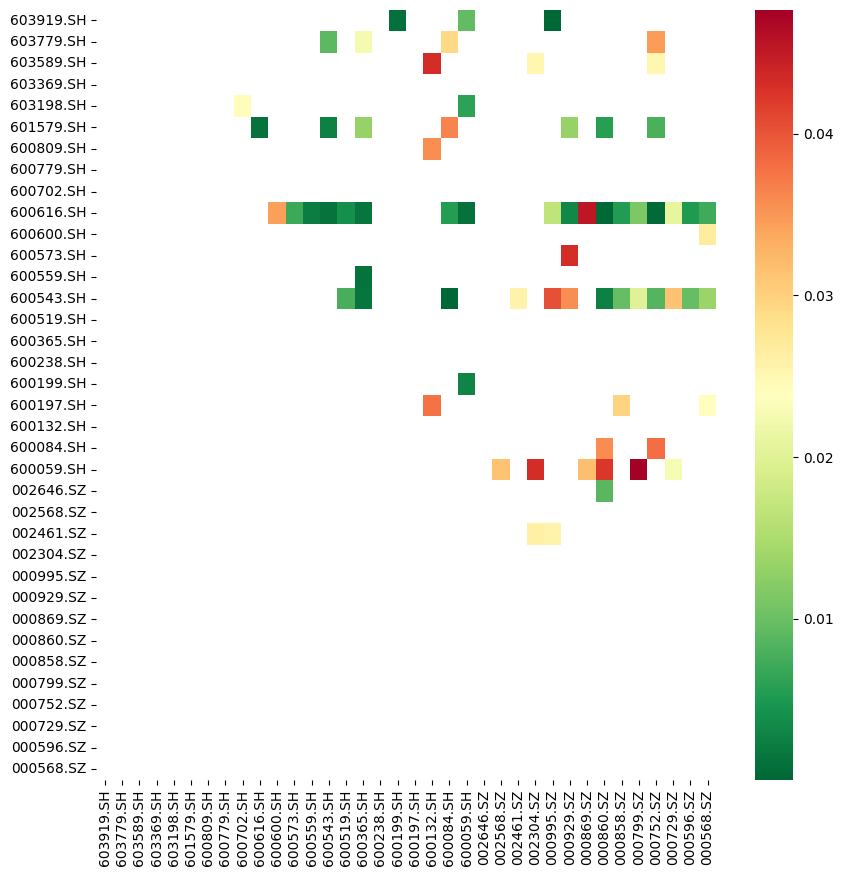

In [5]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
df = pd.read_excel('./data/主题行业类/酒类.xlsx', header=1, index_col=0, skiprows=0)
tickers = df.columns
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r', mask=(pvalues >= 0.05))
print(pairs)

In [7]:
window_size = 60
trade_period = 5

envs = []
for pair in pairs:
    data = df[list(pair)].dropna()
    if data.shape[0] > 700:
        envs.append(StockTradingEnvironment(data.copy(), window_size, trade_period))   #instantiate an env; automatatically run trade()

train_size = int(len(envs) * 0.7)   #train/test split = 0.7
#print(train_size)
train_envs = envs[:train_size]
test_envs = envs[train_size:]

In [8]:
envs[1].df

,603919.SH,600059.SH,ratios,zscore,position1,position2,returns1,returns2,strategy
Date,,,,,,,,,
2016-06-06,30.90,9.77,3.162743,0.807674,0.0,-0.0,0.000000,-0.006122,0.00000
2016-06-07,30.90,9.97,3.099298,1.026758,0.0,-0.0,0.000000,0.020264,0.00000
2016-06-08,30.90,9.77,3.162743,1.331601,0.0,-0.0,0.000000,-0.020264,0.00000
2016-06-13,30.90,9.31,3.319012,1.600097,-1.0,1.0,0.000000,-0.048227,0.00000
2016-06-14,30.90,9.47,3.262936,1.679075,-1.0,1.0,0.000000,0.017040,0.00852
...,...,...,...,...,...,...,...,...,...
2021-07-14,42.31,12.30,3.439837,0.233163,0.0,-0.0,0.020536,0.014742,0.00000
2021-07-15,43.94,12.58,3.492846,0.421498,0.0,-0.0,0.037802,0.022509,0.00000
2021-07-16,42.77,12.40,3.449194,0.640508,0.0,-0.0,-0.026988,-0.014412,0.00000


In [9]:
envs[6].df.columns.get_loc('zscore')

3

In [10]:
env.df.columns.get_loc('zscore')

NameError: name 'env' is not defined

In [151]:
df[list(pair)].shape

(2806, 2)

In [9]:
#shorter df for the immediate last year
testdf = df[list(pairs[0])].iloc[-244:].dropna()

In [10]:
testdf

,603919.SH,600199.SH
Date,,
2020-07-21,16.90,7.21
2020-07-22,17.19,7.12
2020-07-23,17.06,7.03
2020-07-24,16.00,6.72
2020-07-27,16.50,6.77
...,...,...
2021-07-14,42.31,15.80
2021-07-15,43.94,16.58
2021-07-16,42.77,16.31


In [12]:
#test instance
testinst = StockTradingEnvironment(testdf.copy(), 60, 5)

In [135]:
testinst.reset()

array([ 2.4588696 ,  2.53984899,  2.65900154,  2.71581995,  2.66576586,
        2.59195045,  2.53783909,  2.44621165,  2.49477132,  2.53696602,
        2.54203674,  2.48726893,  2.3743048 ,  2.25879143,  2.23316571,
        2.19414831,  2.20935606,  2.24310295,  2.18270262,  1.95423754,
        1.59035463,  1.21809802,  0.92780994,  0.61999021,  0.36962932,
        0.24503848,  0.12969045,  0.05089182,  0.05702688,  0.17366843,
        0.27820012,  0.37228372,  0.34774595,  0.24791743,  0.1436607 ,
        0.0534271 , -0.05217827, -0.09766384, -0.14016936, -0.24718123,
       -0.38661884, -0.58488179, -0.82704686, -1.06458049, -1.26741535,
       -1.48620463, -1.61709077, -1.7041282 , -1.74411933, -1.754482  ,
       -1.7370175 , -1.70565414, -1.63760165, -1.56812378, -1.50441108,
       -1.43248343, -1.38976807, -1.3475575 , -1.29525946, -1.26145768,
        1.        ,  0.50011802])

In [13]:
testinst.reset()

array([ 2.4588696 ,  2.53984899,  2.65900154,  2.71581995,  2.66576586,
        2.59195045,  2.53783909,  2.44621165,  2.49477132,  2.53696602,
        2.54203674,  2.48726893,  2.3743048 ,  2.25879143,  2.23316571,
        2.19414831,  2.20935606,  2.24310295,  2.18270262,  1.95423754,
        1.59035463,  1.21809802,  0.92780994,  0.61999021,  0.36962932,
        0.24503848,  0.12969045,  0.05089182,  0.05702688,  0.17366843,
        0.27820012,  0.37228372,  0.34774595,  0.24791743,  0.1436607 ,
        0.0534271 , -0.05217827, -0.09766384, -0.14016936, -0.24718123,
       -0.38661884, -0.58488179, -0.82704686, -1.06458049, -1.26741535,
       -1.48620463, -1.61709077, -1.7041282 , -1.74411933, -1.754482  ,
       -1.7370175 , -1.70565414, -1.63760165, -1.56812378, -1.50441108,
       -1.43248343, -1.38976807, -1.3475575 , -1.29525946, -1.26145768,
        1.        ,  0.50011802])

/var/folders/8h/dzk7v9l165j6sbd69j9855ch0000gn/T/ipykernel_84640/1411579096.py:114: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mask = pd.Series(self._positionhistory, index=self.df.index[start_index:end_index])


Series([], dtype: float64)
Series([], Name: 603919.SH, dtype: float64)
Series([], Name: 600199.SH, dtype: float64)


ValueError: Axis limits cannot be NaN or Inf

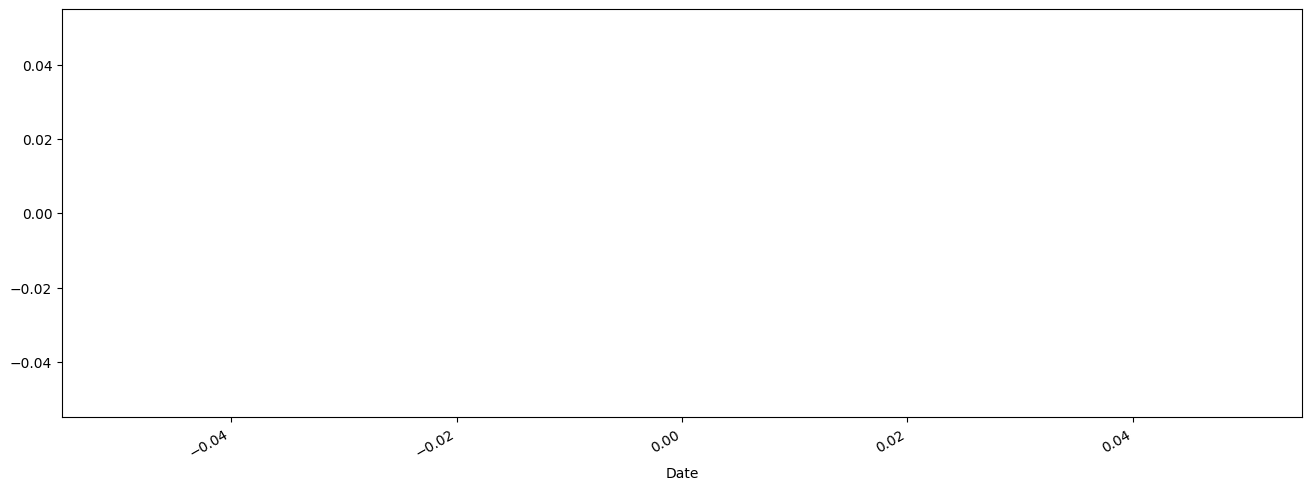

In [14]:
testinst.render()

In [ ]:
testinst.test()

testtesttest


In [ ]:
testinst.test()

testtesttest


In [ ]:
testinst.trade(testdf)

,returns1,returns2,strategy
Date,,,
2021-07-20,1.782299,2.525424,1.086598


In [ ]:
testinst.df

,603919.SH,600199.SH,ratios,zscore,position1,position2,returns1,returns2,strategy
Date,,,,,,,,,
2020-10-21,24.88,6.43,3.869362,2.458870,-1.0,1.0,0.042699,-0.009288,-0.025994
2020-10-22,27.02,6.79,3.979381,2.539849,-1.0,1.0,0.082513,0.054476,-0.014018
2020-10-23,29.72,6.98,4.257880,2.659002,-1.0,1.0,0.095243,0.027598,-0.033822
2020-10-26,26.75,6.66,4.016517,2.715820,-1.0,1.0,-0.105286,-0.046929,0.029178
2020-10-27,27.44,6.72,4.083333,2.665766,-1.0,1.0,0.025467,0.008969,-0.008249
...,...,...,...,...,...,...,...,...,...
2021-07-14,42.31,15.80,2.677848,-0.725918,0.0,-0.0,0.020536,0.009539,0.000000
2021-07-15,43.94,16.58,2.650181,-0.662813,0.0,-0.0,0.037802,0.048187,0.000000
2021-07-16,42.77,16.31,2.622318,-0.606918,0.0,-0.0,-0.026988,-0.016419,0.000000


In [ ]:
testinst.df[['returns1', 'returns2', 'strategy']].dropna().cumsum().apply(np.exp).tail(1)

,returns1,returns2,strategy
Date,,,
2021-07-20,1.782299,2.525424,1.086598


In [236]:
len(train_envs)

48

In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [12]:
class DQN(nn.Module):   #PyTorch's Module class

    def __init__(self, input_size, n_actions):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, n_actions)
        )

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.model(x.to(device))

In [13]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 5

# Get number of actions from gym action space
n_actions = 3

policy_net = DQN(window_size + 2, n_actions).to(device)
target_net = DQN(window_size + 2, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())   #target_net loads state_dict of policy_net
target_net.eval()   #set target_net to evaluate mode

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)   #from torch.optim; RMSprop = optimizer like SGD or Adam
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)   #decreasing from 1 to 0.36xxx
    steps_done += 1
    if sample > eps_threshold:   #epsilon-greedy
        with torch.no_grad():   #disable tracking of grad in autograd; reduce memory usage and speed up computations; no backprop
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #print(policy_net(state)).max(1)
            return policy_net(state).max(1)[1].view(1, 1)   #exploit
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)   #explore, because random

In [250]:
tuple(map(lambda s: s is not None, [None,2]))

(False, True)

In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:   #min memory = 128
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))   #batch is a namedtuple; tuple (state, action, next_state, reward) from memory

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,   #lambda s: s is not None will return a tuple of bools over bench.next_state
                                          batch.next_state)), device=device, dtype=torch.bool)   #next_state is an observation
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    #Q(s_t, a) is what the policy_net says based on state_batch
    state_action_values = policy_net(state_batch).gather(1, action_batch)   #gather from policy_net(state_batch) (axis, index)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)   #initialize next_state_values
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()   #what target_net says
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch   
    #Bellman equation: expected state_action values (from target network) * GAMMA + immediate reward should equal to
    #state_action values returned by policy network; difference = loss

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()   #set optimizer's grad to zero
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)   #clamp_ is inplace version of clamp: clamp grad.data into -1 and 1 range
    optimizer.step()   #update parameters of optimizer

In [16]:
#num_episodes = 5
num_episodes = 1
#num_episodes = 300
best_rewards = 0.0
for i_episode in range(num_episodes):
    policy_net.train()   #sets mode to training mode
    train_rewards = []
    train_returns = []
    for env in train_envs:
    #for env in [testinst]:
        # Initialize the environment and state
        obs = env.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor([obs], dtype=torch.float, device=device)   
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = select_action(state)   #epsilon-greedy: exploit or explore; state is this state
            obs, reward, done, info = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            #reward is step_reward for this step
            
            reward = torch.tensor([reward], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor([obs], dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()   #optimize policy network with back propagation
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:   #update target network every 5 episodes
        target_net.load_state_dict(policy_net.state_dict())   #update target network with policy network parameters
    
    # Validation
    policy_net.eval()   #validate, so set policy network at eval mode
    test_rewards = []
    test_returns = []
    with torch.no_grad():
        for env in test_envs:
            obs = env.reset()
            state = torch.tensor([obs], dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)   #action returned by policy_net given state
                obs, _reward, done, info = env.step(Positions(action.item()))   #take a step based on action returned by nn
                state = torch.tensor([obs], dtype=torch.float, device=device)

                if done:
                    test_rewards.append(info['total_reward'])
                    test_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(test_rewards)
    if avg_rewards > best_rewards:
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, return:{:.4f}, val rewards:{:.4f}, return:{:.4f}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(test_rewards),
           np.mean(test_returns)))


print('Complete')

epoch [1/1], train rewards:-0.0340, return:-0.0340, val rewards:-0.2073, return:-0.2073
Complete


In [17]:
policy_net

DQN(
  (model): Sequential(
    (0): Linear(in_features=62, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [ ]:
len(train_envs)

48

action = tensor[0] or [1] or [2]

obs = get_observation

reward = step_reward += -0.5 * return1 + 0.5 * return2    #Positions.Short, then step_reward = short S1 long S2

reward = step_reward += 0.5 * return1 - 0.5 * return2    #Positions.Long, then step_reward = long S1 short S2

done = bool

info = dict: total_reward, total_return

state = 62 states

In [18]:
env.df.iloc[-244:]
        

,002461.SZ,000995.SZ,ratios,zscore,position1,position2,returns1,returns2,strategy
Date,,,,,,,,,
2020-07-21,12.90,7.47,1.726908,2.082335,-1.0,1.0,0.072321,0.000000,-0.036160
2020-07-22,12.99,7.47,1.738956,2.105704,-1.0,1.0,0.006953,0.000000,-0.003476
2020-07-23,13.55,7.47,1.813922,2.293654,-1.0,1.0,0.042207,0.000000,-0.021103
2020-07-24,12.93,7.47,1.730924,2.296982,-1.0,1.0,-0.046836,0.000000,0.023418
2020-07-27,12.52,7.47,1.676037,2.268613,-1.0,1.0,-0.032223,0.000000,0.016111
...,...,...,...,...,...,...,...,...,...
2021-07-14,10.34,28.96,0.357044,-0.841823,1.0,-1.0,-0.008666,0.049550,-0.029108
2021-07-15,10.98,27.77,0.395391,-0.814471,1.0,-1.0,0.060056,-0.041959,0.051007
2021-07-16,10.84,26.56,0.408133,-0.767368,1.0,-1.0,-0.012832,-0.044550,0.015859


In [19]:
env.df

,002461.SZ,000995.SZ,ratios,zscore,position1,position2,returns1,returns2,strategy
Date,,,,,,,,,
2010-11-22,21.38,14.66,1.458390,-1.707921,1.0,-1.0,0.001404,0.027664,-0.013130
2010-11-23,20.58,14.27,1.442186,-1.730696,1.0,-1.0,-0.038136,-0.026963,-0.005586
2010-11-24,21.46,14.64,1.465847,-1.731864,1.0,-1.0,0.041871,0.025598,0.008136
2010-11-25,21.60,14.58,1.481481,-1.700057,1.0,-1.0,0.006503,-0.004107,0.005305
2010-11-26,21.33,14.52,1.469008,-1.654903,1.0,-1.0,-0.012579,-0.004124,-0.004228
...,...,...,...,...,...,...,...,...,...
2021-07-14,10.34,28.96,0.357044,-0.841823,1.0,-1.0,-0.008666,0.049550,-0.029108
2021-07-15,10.98,27.77,0.395391,-0.814471,1.0,-1.0,0.060056,-0.041959,0.051007
2021-07-16,10.84,26.56,0.408133,-0.767368,1.0,-1.0,-0.012832,-0.044550,0.015859


In [20]:
Positions.Long.value

0

In [21]:
env._positionhistory[-244:]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [22]:
start_index = 60
#start_index = self.window_size
#start_index = len(self._positionhistory) - 244   #to shorten the plot
end_index = start_index + len(env._positionhistory)
mask = pd.Series(env._positionhistory, index=env.df.index[start_index:end_index])
        

In [98]:
end_index

2590

In [245]:
mask.unique()

array([1, 0, 2])

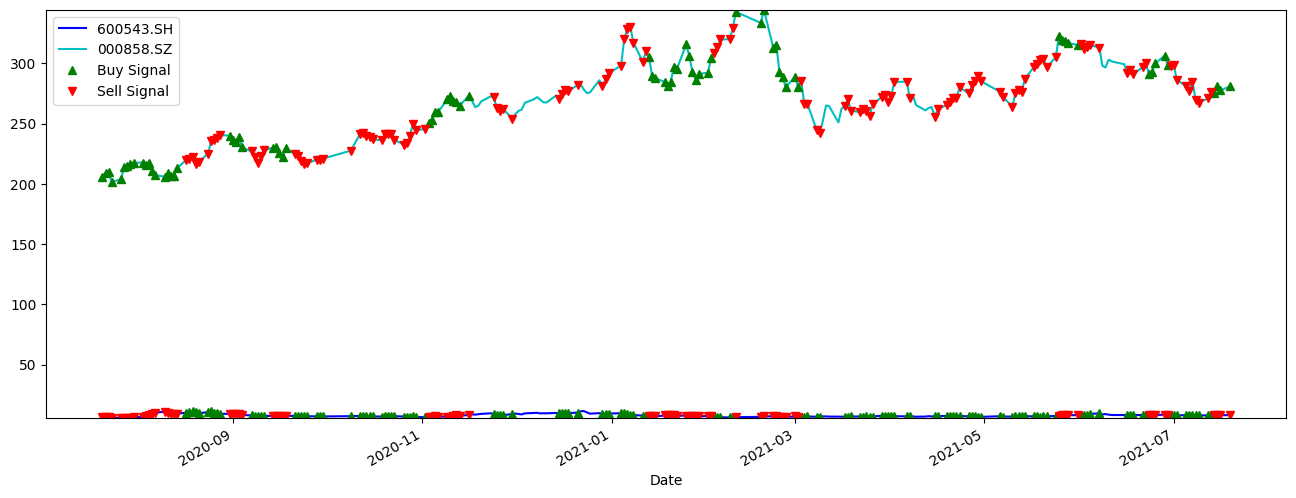

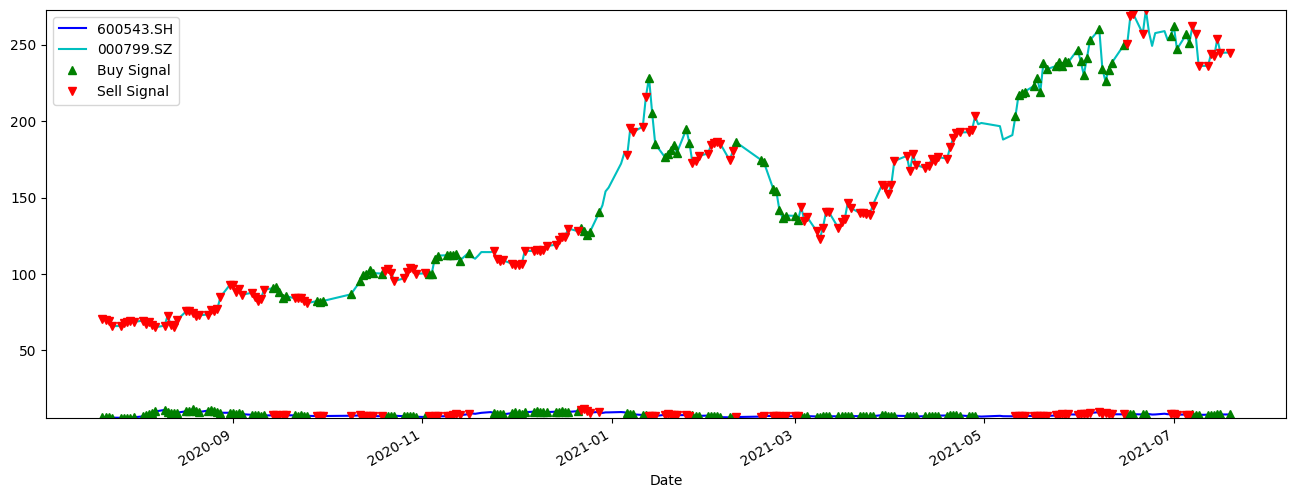

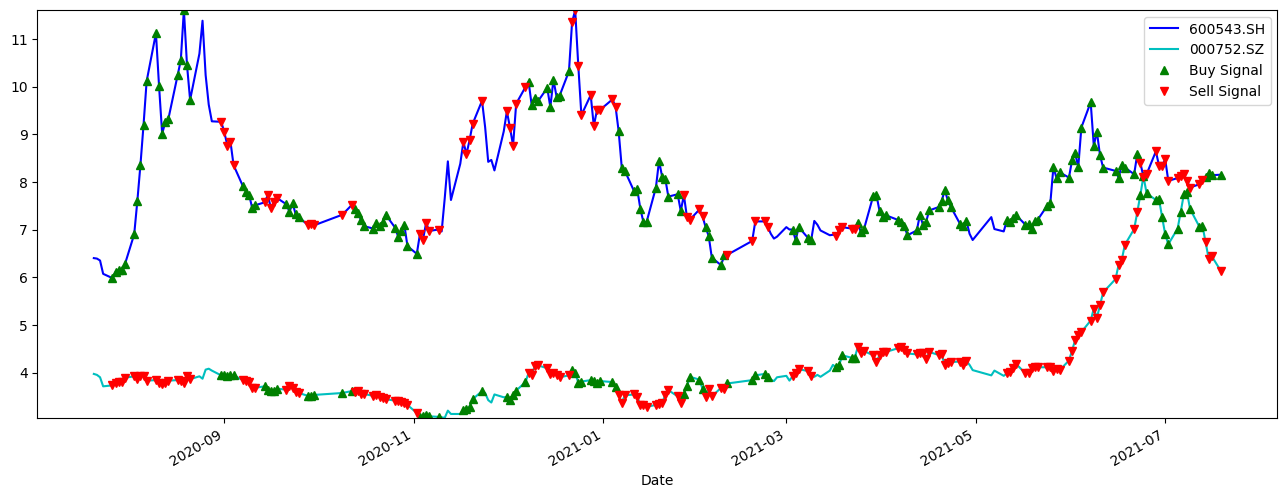

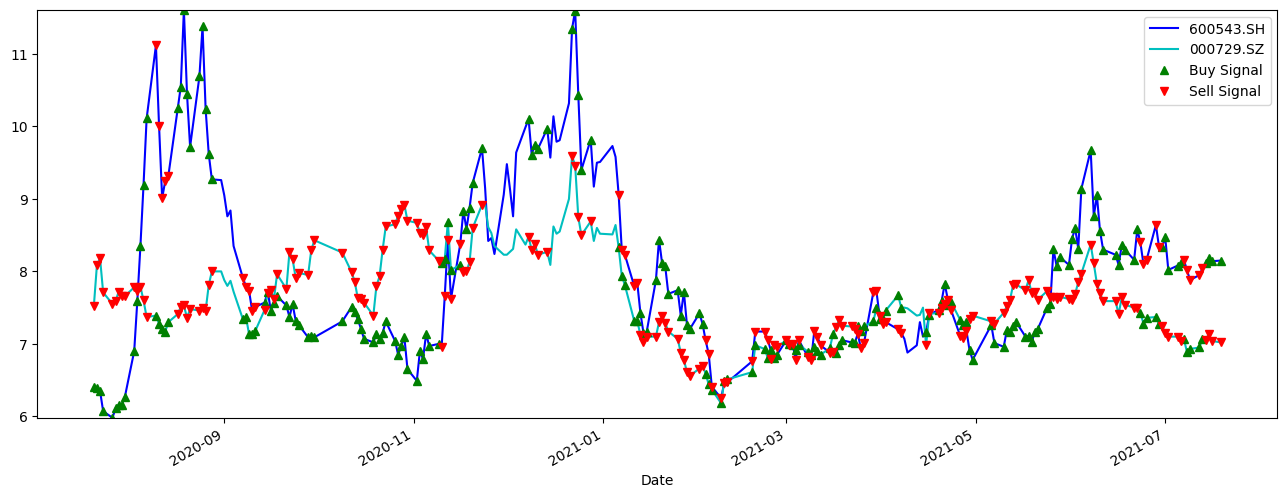

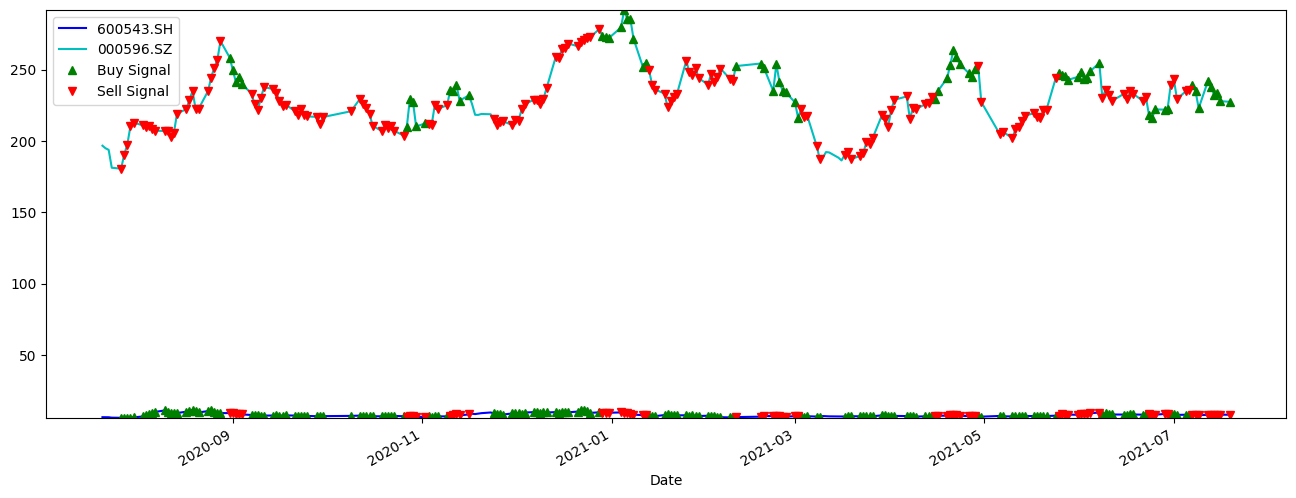

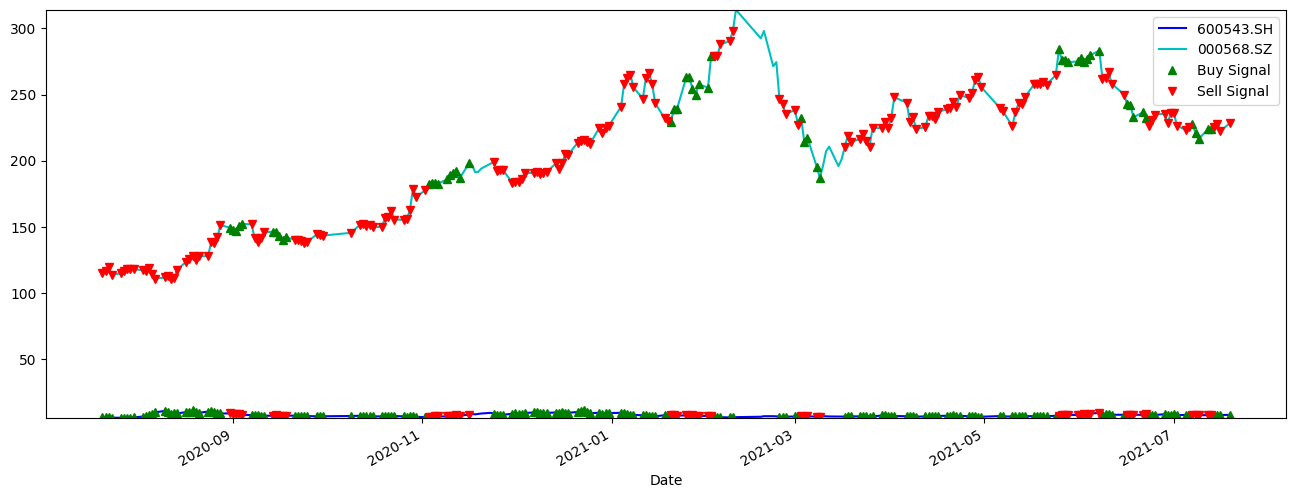

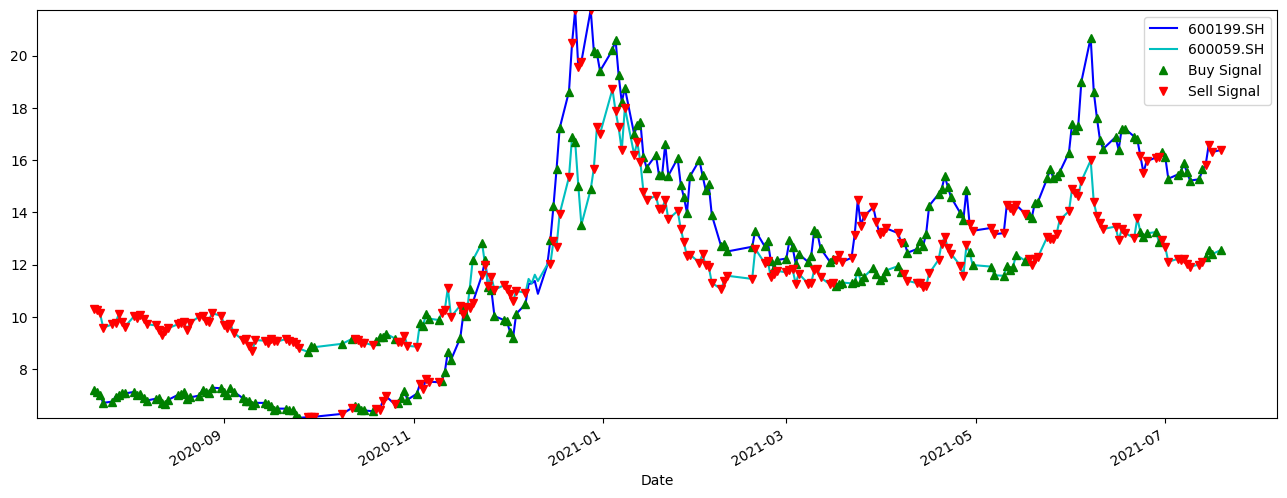

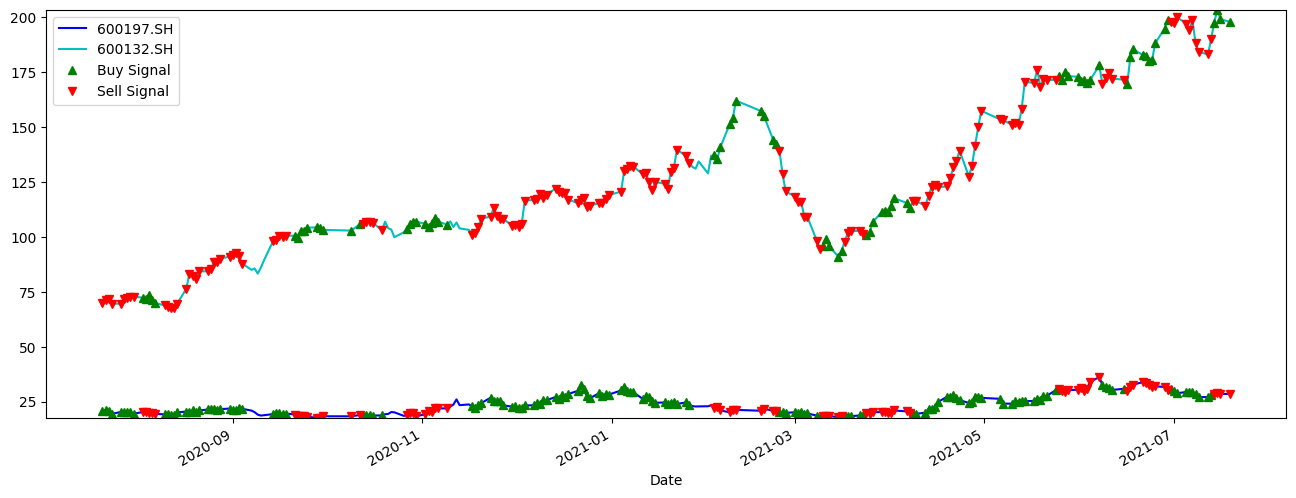

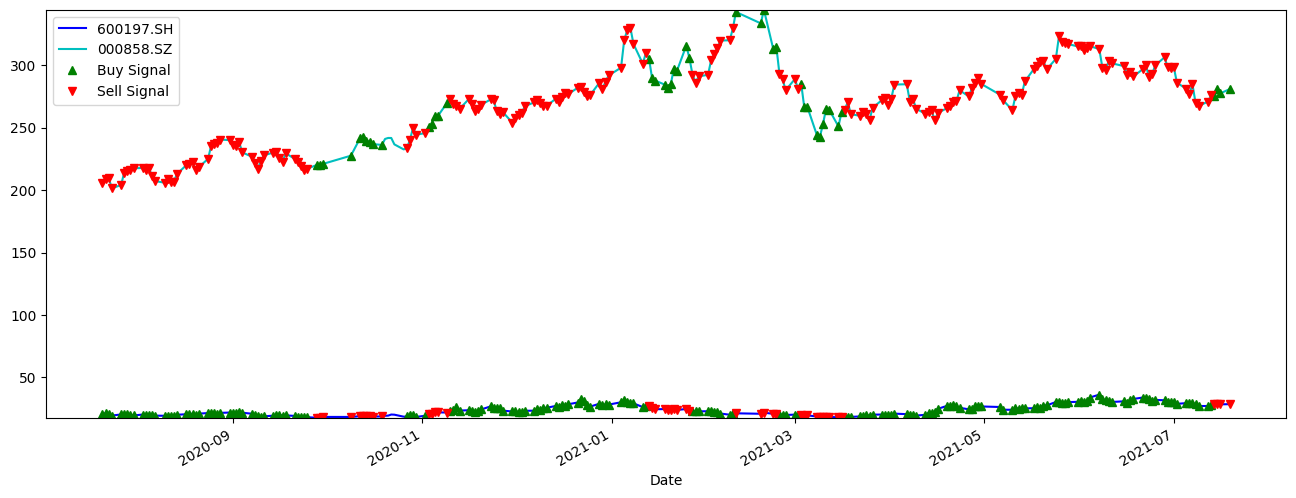

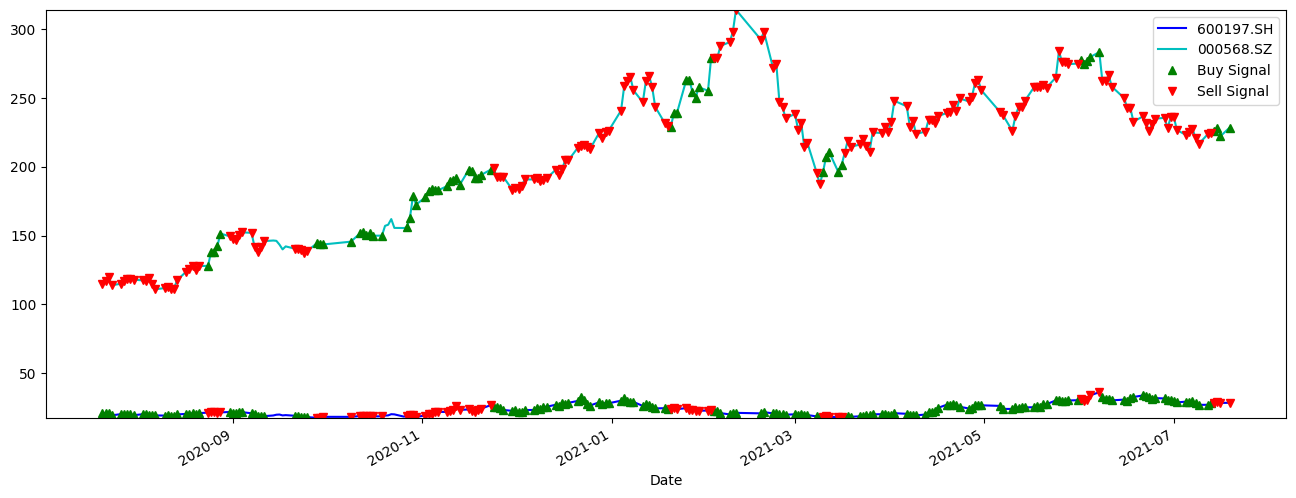

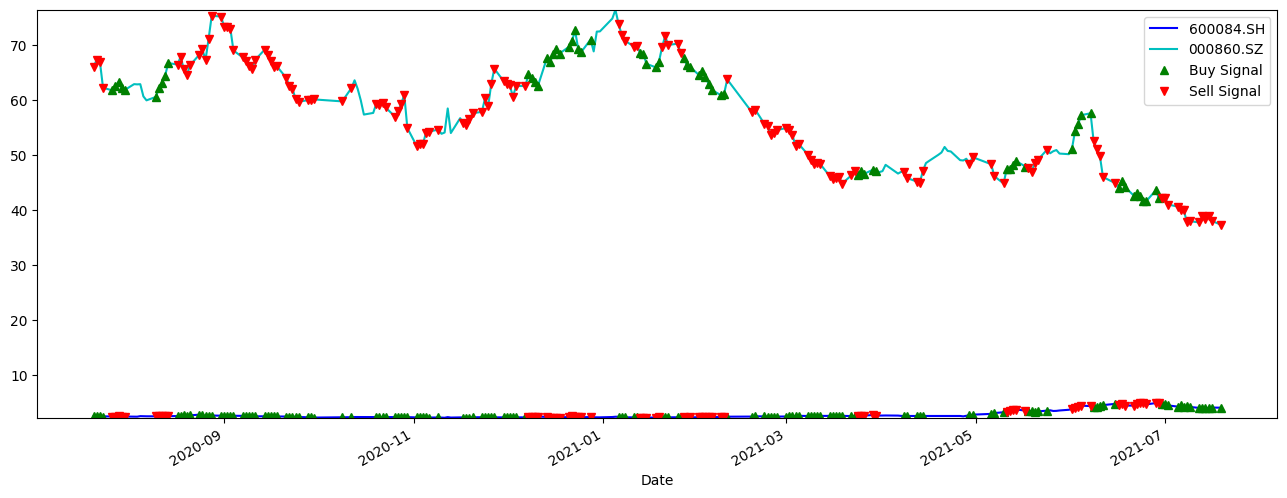

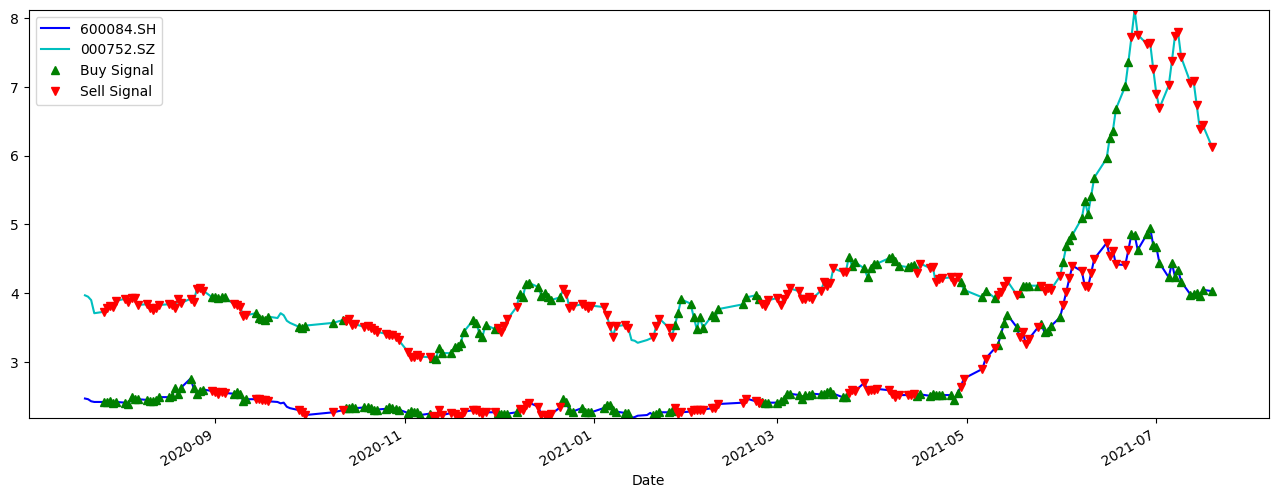

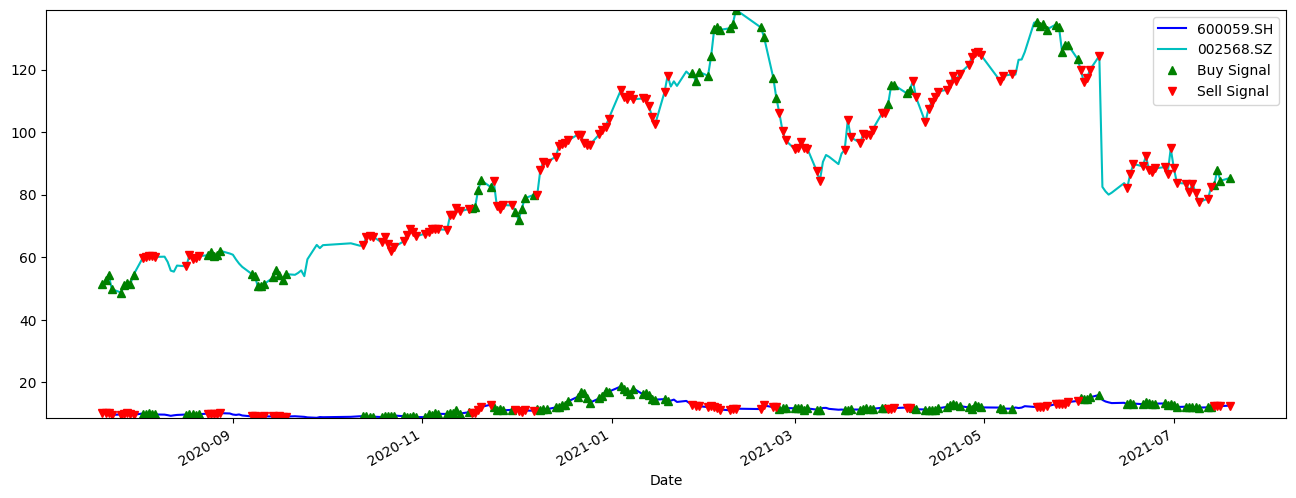

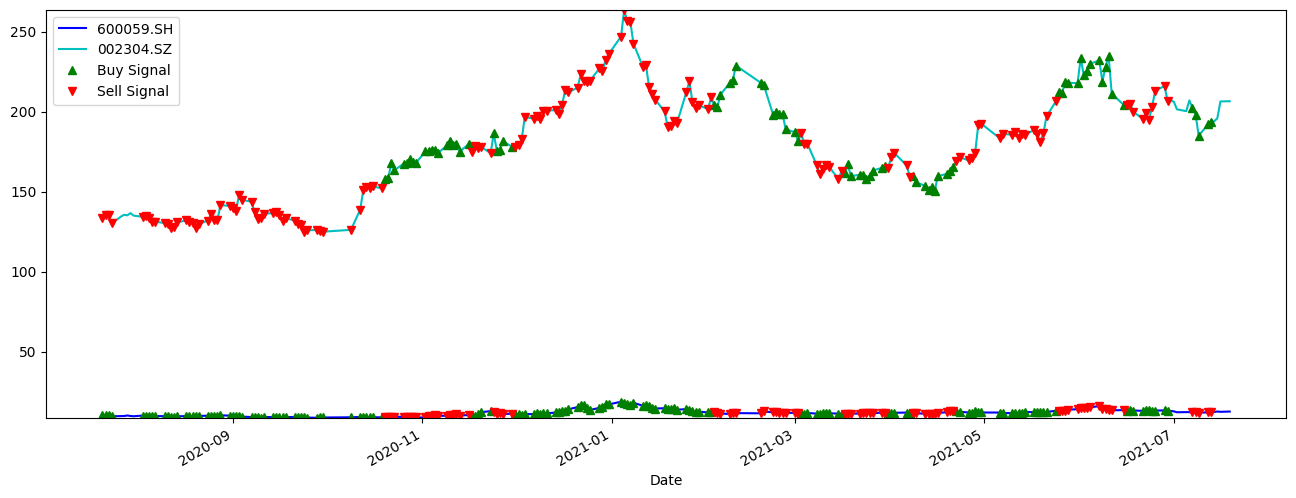

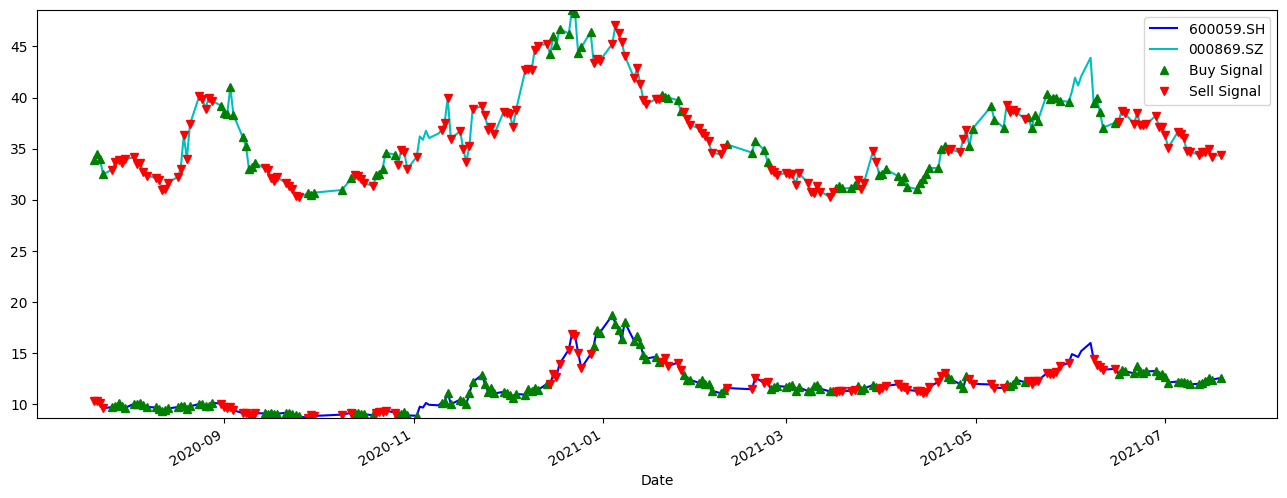

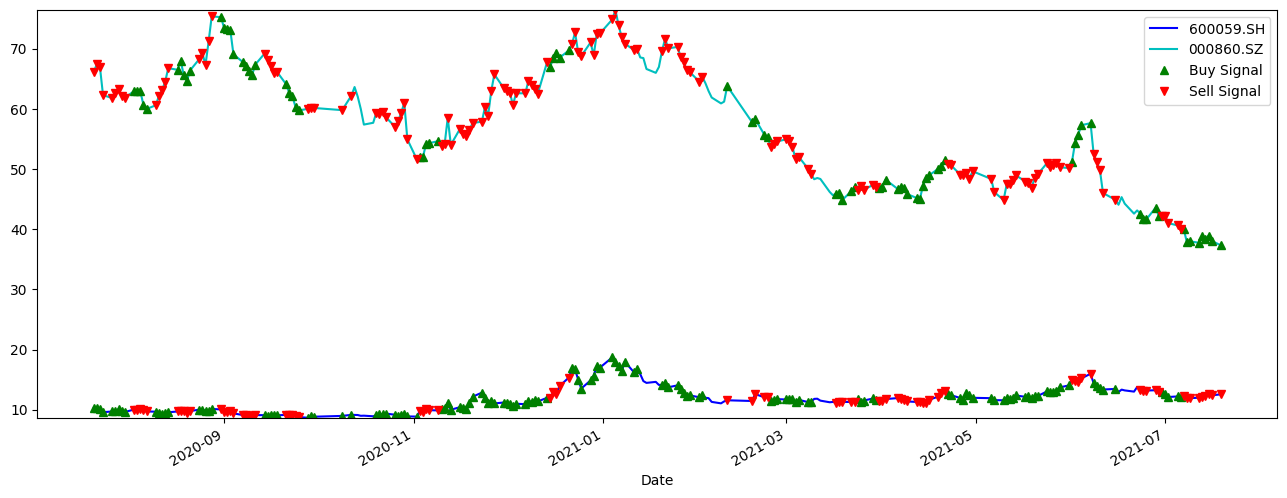

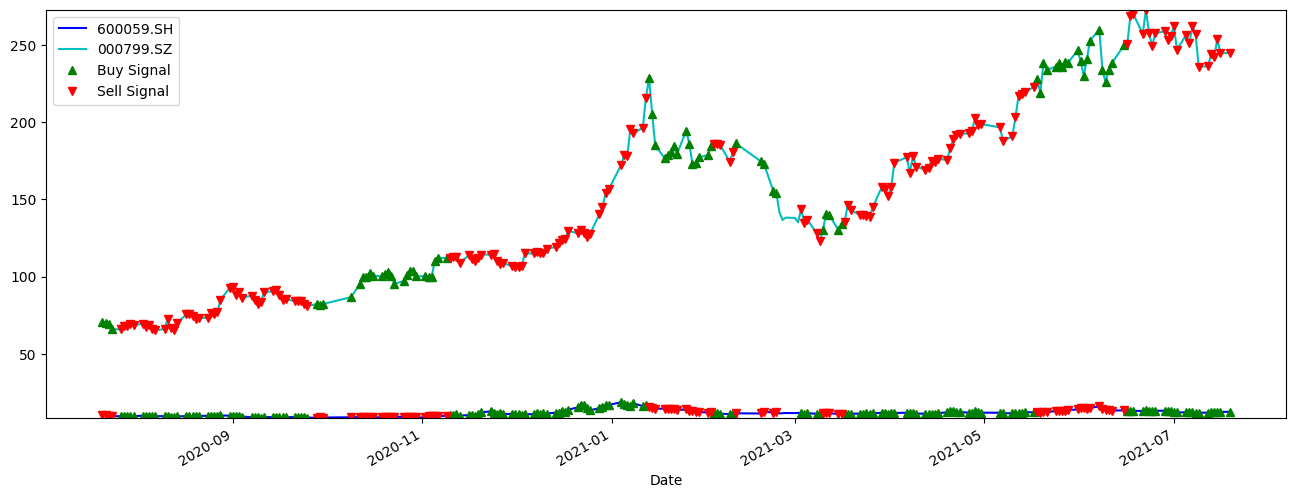

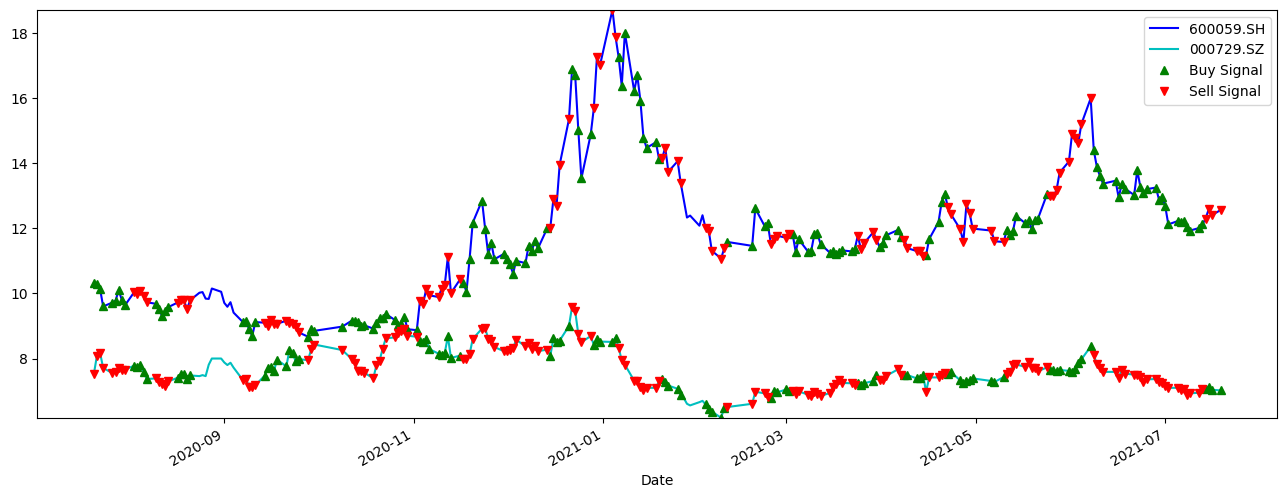

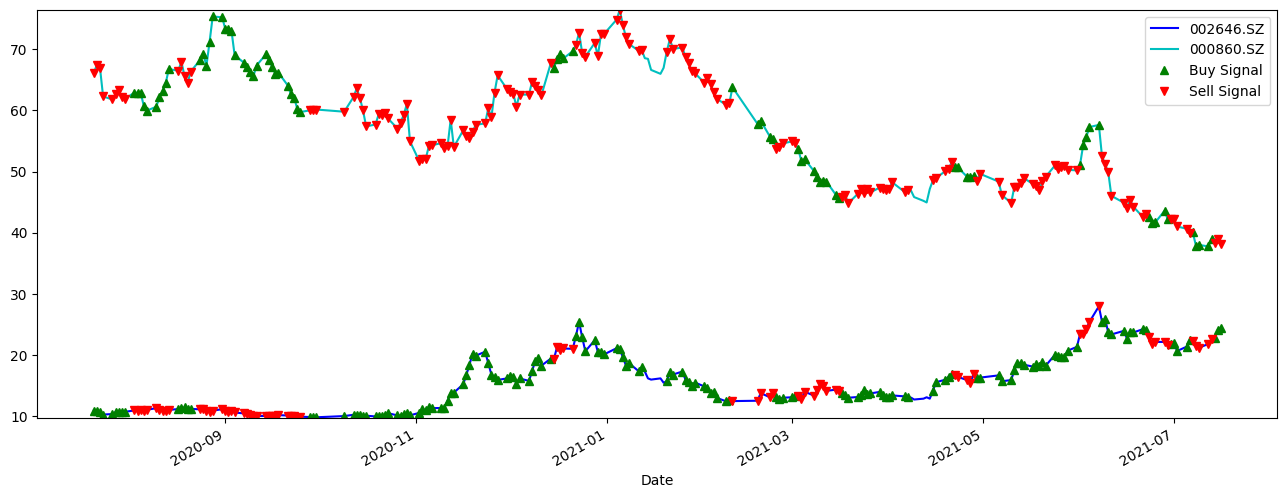

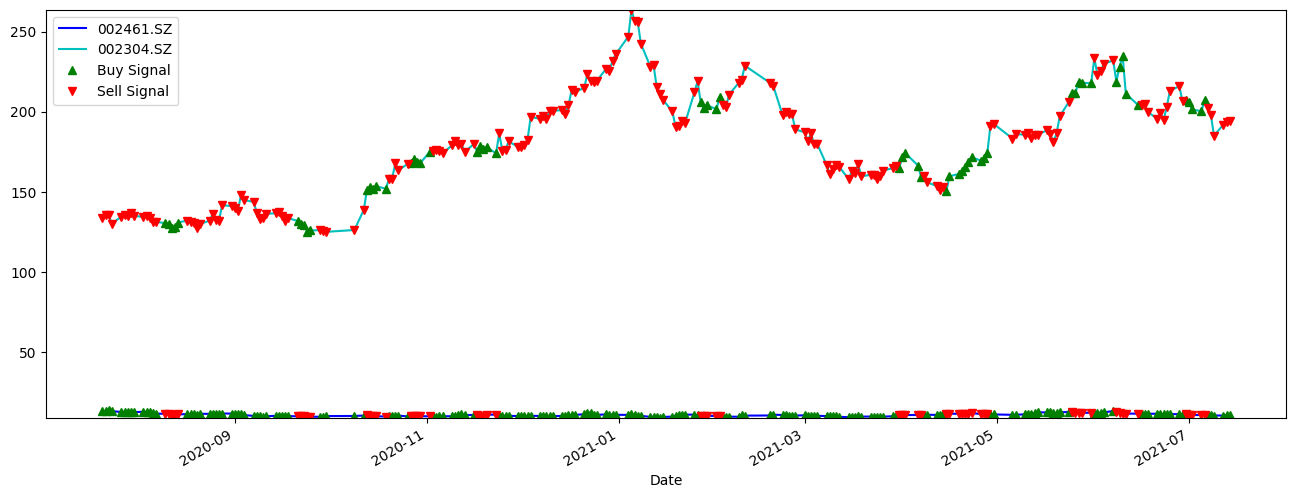

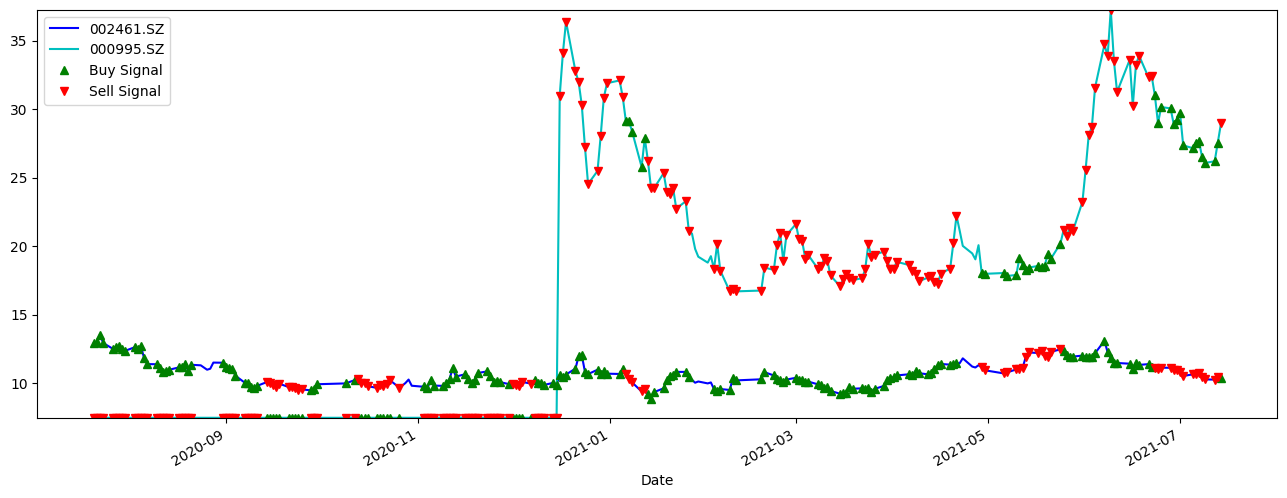

-0.8008915813375594


In [23]:
#policy_net.load_state_dict(torch.load('./models/model (19).pth'))
policy_net.load_state_dict(torch.load('./models/model (6).pth'))   #copies parameters from state_dict to this module
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

returns = []
with torch.no_grad():
    for env in test_envs:
    #for env in [test_envs[1]]:

        obs = env.reset()
        state = torch.tensor([obs], dtype=torch.float, device=device)
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = policy_net(state).max(1)[1].view(1, 1)
            obs, reward, done, info = env.step(Positions(action.item()))
            state = torch.tensor([obs], dtype=torch.float, device=device)
            #print(state)

            if done:
                #print(f'env.returns\n{env.returns}')
                #print(f'env.total_reward{env._total_reward}')
                env.render()
                returns.append(info['total_return'])
                break

avg_returns = np.mean(returns)
print(avg_returns)

plt.ioff()
plt.show()

In [ ]:
Positions(action.item())

<Positions.Short: 0>

In [21]:
test_envs[0].df

,600543.SH,000858.SZ,ratios,zscore,position1,position2,returns1,returns2,strategy
Date,,,,,,,,,
2010-04-06,12.00,28.04,0.427960,-0.043434,0.0,-0.0,-0.014889,-0.009230,0.0
2010-04-07,11.88,28.36,0.418900,-0.028455,0.0,-0.0,-0.010050,0.011348,-0.0
2010-04-08,11.91,27.76,0.429035,-0.023734,0.0,-0.0,0.002522,-0.021384,0.0
2010-04-09,12.05,28.05,0.429590,0.025610,0.0,-0.0,0.011686,0.010392,0.0
2010-04-12,12.19,27.52,0.442951,0.195577,0.0,-0.0,0.011551,-0.019076,0.0
...,...,...,...,...,...,...,...,...,...
2021-07-14,8.11,275.30,0.029459,1.192199,0.0,-0.0,0.008669,-0.002539,0.0
2021-07-15,8.18,280.83,0.029128,1.116917,0.0,-0.0,0.008594,0.019888,0.0
2021-07-16,8.14,277.52,0.029331,1.081904,0.0,-0.0,-0.004902,-0.011857,0.0


In [30]:
env.plot_ratios(mask)

NameError: name 'mask' is not defined

In [26]:
env.get_observation()

array([ 1.6456393 ,  1.69994203,  1.6121919 ,  1.17116738,  0.70791341,
        0.49220369,  0.28231175,  0.33163876,  0.52578213,  0.81065002,
        0.8498165 ,  0.89961637,  0.95076599,  1.12619571,  0.93018687,
        0.85288347,  1.03540377,  1.20477318,  1.33735685,  1.6424206 ,
        1.79683237,  1.6296441 ,  1.50297121,  1.32210901,  0.99042736,
        0.73686185,  0.50510593,  0.17612378, -0.23804205, -0.6849999 ,
       -1.19995276, -1.59894898, -2.02059621, -2.26660196, -2.38129286,
       -2.41575328, -2.41616669, -2.32770175, -2.26648371, -2.1578047 ,
       -1.98273385, -1.88796502, -1.83248792, -1.74408091, -1.70426996,
       -1.59812967, -1.49019038, -1.41646325, -1.31331564, -1.24064728,
       -1.22550451, -1.16383018, -1.09472096, -1.04982904, -0.99667683,
       -0.91658065, -0.87238548, -0.84401098, -0.82711078, -0.84182319,
        0.        ,  0.02573553])